# Disengagement Pathway Analysis

The churn drivers analysis found that listening activity does not predict churn overall. This notebook investigates whether that finding holds when looking deeper, removing the potential confound of auto-renew obscuring real effects. Specifically, whether the *pattern* of behavioral decline predicts churn among users without auto-renew.

In [1]:
from google.cloud import bigquery
from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os

warnings.filterwarnings("ignore")
load_dotenv()

GCP_PROJECT = os.environ.get("GCP_PROJECT")
client = bigquery.Client(project=GCP_PROJECT)

def run_query(sql):
    return client.query(sql).to_dataframe()

## Methodology

When users disengage before churning, which behavioral dimension declines most steeply? The pattern of decline across volume, completion, and exploration may reveal distinct disengagement pathways with different churn rates.

**Periods:** Baseline (Aug-Oct 2016), Transition (Nov-Dec 2016), Final (Jan 2017)

**Dimensions:**
- Volume: total listening seconds
- Completion rate: songs finished / songs started
- Exploration rate: unique songs / songs played

**Classification:** Users are classified by which dimension showed the steepest decline (>15%) from baseline to transition. "Volume-Led" means volume had the largest decline, not that it declined first temporally.

In [ ]:
# Check user coverage across analysis periods
run_query("""
WITH period_activity AS (
    SELECT 
        msno,
        MAX(CASE WHEN date BETWEEN 20160801 AND 20161031 THEN 1 ELSE 0 END) AS has_baseline,
        MAX(CASE WHEN date BETWEEN 20161101 AND 20161231 THEN 1 ELSE 0 END) AS has_transition,
        MAX(CASE WHEN date BETWEEN 20170101 AND 20170131 THEN 1 ELSE 0 END) AS has_final
    FROM kkbox.user_logs
    WHERE date >= 20160801 AND date <= 20170131
    GROUP BY msno
)

SELECT 
    has_baseline,
    has_transition,
    has_final,
    COUNT(*) AS user_count
FROM period_activity
GROUP BY has_baseline, has_transition, has_final
ORDER BY user_count DESC
""")

,has_baseline,has_transition,has_final,user_count
0,1,1,1,877026
1,1,0,0,508378
2,0,1,0,290272
3,0,0,1,156867
4,1,1,0,122306
5,0,1,1,86867
6,1,0,1,15243


877K users have listening activity in all three periods (Aug-Oct, Nov-Dec, Jan). 508K users appear only in baseline, suggesting they stopped using the service before November. 122K users have baseline and transition activity but nothing in January, a pattern consistent with disengagement in the final month before the February expiration window.

In [ ]:
# Calculate behavioral dimensions by period for users active in all three periods
run_query("""
WITH user_periods AS (
    SELECT 
        msno,
        CASE 
            WHEN date BETWEEN 20160801 AND 20161031 THEN 'baseline'
            WHEN date BETWEEN 20161101 AND 20161231 THEN 'transition'
            WHEN date BETWEEN 20170101 AND 20170131 THEN 'final'
        END AS period,
        SUM(total_secs) AS total_secs,
        SUM(num_100) AS songs_completed,
        SUM(num_25 + num_50 + num_75 + num_985 + num_100) AS songs_played,
        SUM(num_unq) AS unique_songs
    FROM kkbox.user_logs
    WHERE date >= 20160801 AND date <= 20170131
        AND total_secs BETWEEN 0 AND 57600
    GROUP BY msno, period
),

users_all_periods AS (
    SELECT msno
    FROM user_periods
    GROUP BY msno
    HAVING COUNT(DISTINCT period) = 3
),

dimensions AS (
    SELECT 
        p.msno,
        p.period,
        p.total_secs AS volume,
        SAFE_DIVIDE(p.songs_completed, p.songs_played) AS completion_rate,
        SAFE_DIVIDE(p.unique_songs, p.songs_played) AS exploration_rate
    FROM user_periods p
    INNER JOIN users_all_periods u ON p.msno = u.msno
)

SELECT 
    msno,
    MAX(CASE WHEN period = 'baseline' THEN volume END) AS baseline_volume,
    MAX(CASE WHEN period = 'transition' THEN volume END) AS transition_volume,
    MAX(CASE WHEN period = 'final' THEN volume END) AS final_volume,
    MAX(CASE WHEN period = 'baseline' THEN completion_rate END) AS baseline_completion,
    MAX(CASE WHEN period = 'transition' THEN completion_rate END) AS transition_completion,
    MAX(CASE WHEN period = 'final' THEN completion_rate END) AS final_completion,
    MAX(CASE WHEN period = 'baseline' THEN exploration_rate END) AS baseline_exploration,
    MAX(CASE WHEN period = 'transition' THEN exploration_rate END) AS transition_exploration,
    MAX(CASE WHEN period = 'final' THEN exploration_rate END) AS final_exploration
FROM dimensions
GROUP BY msno
LIMIT 10
""")

,msno,baseline_volume,transition_volume,final_volume,baseline_completion,transition_completion,final_completion,baseline_exploration,transition_exploration,final_exploration
0,Ej8sbhrdfZv4dMa2Q4oEmjt5z5e42RigRXQI6E+48xY=,251233.149,242916.930,123741.814,0.749175,0.626126,0.638239,0.834158,0.915916,0.756534
1,rXIGj3qdP6g6rraT6xhT4mBpp86JjkfYF0j2KEA9QnM=,624819.184,654721.403,660891.490,0.821098,0.840176,0.878240,0.706344,0.806922,0.761255
2,qeBDcfu4yGqKunJG7W5mpDKATs9i2MCuU62ZQ3AL7uI=,582376.362,176393.496,122646.294,0.538806,0.577163,0.614627,0.943699,0.958073,0.779184
3,T9HnnT6PpKuFrLAOOaZnT3neq8D8chXVzdDXkFNaE0k=,1368821.815,460795.738,481033.180,0.781162,0.712897,0.806250,0.834161,0.884860,0.847656
4,TInLvgmiML64em9GYdMYJRZDTXRrxyHeTSYtDeFyzn8=,694742.904,1088641.000,421554.821,0.784818,0.876622,0.919653,0.881949,0.926880,0.802389
5,Se6NpErpHshyHaefw4L0Ts6YuoojVZ9Per4Fr2rb+Ho=,282576.305,666477.158,134398.282,0.438839,0.478021,0.557342,0.636607,0.712990,0.624866
6,TlG487KgqUnNEJmq1t5pZraeQK8cbolf/pj22xhgMmQ=,416203.619,161807.876,105847.888,0.844242,0.887597,0.855072,0.825977,0.781654,0.790890
7,o4EnGvgX9K8pwI9KX888y/RtbMk75eCrVY/KLHQ4H4s=,107476.901,483445.346,108793.789,0.714000,0.737799,0.568106,0.814000,0.843833,0.890365
8,wUcR3xXQje5GSV6pIKEH/GhK5mWdAra9Dko4nzYmC48=,298039.428,214464.538,78376.433,0.381150,0.510848,0.515044,0.768191,0.850099,0.837168
9,pAKm2yYNlbWV3LAbpmb6met8V7ijAjlxR5OjGarxz6U=,150880.863,49976.977,27723.880,0.739583,0.718487,0.583333,0.864583,0.907563,0.868056


Volume is in total seconds per period. Completion rate and exploration rate are proportions. The sample shows varied patterns: some users show volume drops while completion stays flat, others show completion drops while volume increases.

In [ ]:
# Percent change in each dimension (baseline to transition)
run_query("""
WITH user_periods AS (
    SELECT 
        msno,
        CASE 
            WHEN date BETWEEN 20160801 AND 20161031 THEN 'baseline'
            WHEN date BETWEEN 20161101 AND 20161231 THEN 'transition'
            WHEN date BETWEEN 20170101 AND 20170131 THEN 'final'
        END AS period,
        SUM(total_secs) AS total_secs,
        SUM(num_100) AS songs_completed,
        SUM(num_25 + num_50 + num_75 + num_985 + num_100) AS songs_played,
        SUM(num_unq) AS unique_songs
    FROM kkbox.user_logs
    WHERE date >= 20160801 AND date <= 20170131
        AND total_secs BETWEEN 0 AND 57600
    GROUP BY msno, period
),

users_all_periods AS (
    SELECT msno
    FROM user_periods
    GROUP BY msno
    HAVING COUNT(DISTINCT period) = 3
),

dimensions AS (
    SELECT 
        p.msno,
        p.period,
        p.total_secs AS volume,
        SAFE_DIVIDE(p.songs_completed, p.songs_played) AS completion_rate,
        SAFE_DIVIDE(p.unique_songs, p.songs_played) AS exploration_rate
    FROM user_periods p
    INNER JOIN users_all_periods u ON p.msno = u.msno
),

wide AS (
    SELECT 
        msno,
        MAX(CASE WHEN period = 'baseline' THEN volume END) AS baseline_volume,
        MAX(CASE WHEN period = 'transition' THEN volume END) AS transition_volume,
        MAX(CASE WHEN period = 'baseline' THEN completion_rate END) AS baseline_completion,
        MAX(CASE WHEN period = 'transition' THEN completion_rate END) AS transition_completion,
        MAX(CASE WHEN period = 'baseline' THEN exploration_rate END) AS baseline_exploration,
        MAX(CASE WHEN period = 'transition' THEN exploration_rate END) AS transition_exploration
    FROM dimensions
    GROUP BY msno
),

changes AS (
    SELECT 
        msno,
        SAFE_DIVIDE(transition_volume - baseline_volume, baseline_volume) AS volume_change,
        SAFE_DIVIDE(transition_completion - baseline_completion, baseline_completion) AS completion_change,
        SAFE_DIVIDE(transition_exploration - baseline_exploration, baseline_exploration) AS exploration_change
    FROM wide
)

SELECT 
    ROUND(volume_change, 2) AS volume_change,
    ROUND(completion_change, 2) AS completion_change,
    ROUND(exploration_change, 2) AS exploration_change
FROM changes
WHERE volume_change IS NOT NULL 
    AND completion_change IS NOT NULL 
    AND exploration_change IS NOT NULL
ORDER BY msno
LIMIT 20
""")

,volume_change,completion_change,exploration_change
0,0.61,0.04,0.05
1,-0.48,-0.09,0.00
2,0.34,0.34,-0.12
3,-0.33,0.20,-0.13
4,-0.31,0.05,-0.04
5,1.62,-0.76,0.02
6,-0.54,0.00,-0.01
7,0.10,-0.36,-0.11
8,-0.68,-0.19,0.03
9,0.23,0.23,-0.23


Percentage changes show wide variability across dimensions. Some users show volume as the steepest decline, others show completion or exploration declining most while other dimensions increase. This variability motivates classifying users by which dimension declined most steeply.

In [ ]:
# Classify users by which dimension declined most
run_query("""
WITH user_periods AS (
    SELECT 
        msno,
        CASE 
            WHEN date BETWEEN 20160801 AND 20161031 THEN 'baseline'
            WHEN date BETWEEN 20161101 AND 20161231 THEN 'transition'
            WHEN date BETWEEN 20170101 AND 20170131 THEN 'final'
        END AS period,
        SUM(total_secs) AS total_secs,
        SUM(num_100) AS songs_completed,
        SUM(num_25 + num_50 + num_75 + num_985 + num_100) AS songs_played,
        SUM(num_unq) AS unique_songs
    FROM kkbox.user_logs
    WHERE date >= 20160801 AND date <= 20170131
        AND total_secs BETWEEN 0 AND 57600
    GROUP BY msno, period
),

users_all_periods AS (
    SELECT msno
    FROM user_periods
    GROUP BY msno
    HAVING COUNT(DISTINCT period) = 3
),

dimensions AS (
    SELECT 
        p.msno,
        p.period,
        p.total_secs AS volume,
        SAFE_DIVIDE(p.songs_completed, p.songs_played) AS completion_rate,
        SAFE_DIVIDE(p.unique_songs, p.songs_played) AS exploration_rate
    FROM user_periods p
    INNER JOIN users_all_periods u ON p.msno = u.msno
),

wide AS (
    SELECT 
        msno,
        MAX(CASE WHEN period = 'baseline' THEN volume END) AS baseline_volume,
        MAX(CASE WHEN period = 'transition' THEN volume END) AS transition_volume,
        MAX(CASE WHEN period = 'baseline' THEN completion_rate END) AS baseline_completion,
        MAX(CASE WHEN period = 'transition' THEN completion_rate END) AS transition_completion,
        MAX(CASE WHEN period = 'baseline' THEN exploration_rate END) AS baseline_exploration,
        MAX(CASE WHEN period = 'transition' THEN exploration_rate END) AS transition_exploration
    FROM dimensions
    GROUP BY msno
),

changes AS (
    SELECT 
        msno,
        SAFE_DIVIDE(transition_volume - baseline_volume, baseline_volume) AS volume_change,
        SAFE_DIVIDE(transition_completion - baseline_completion, baseline_completion) AS completion_change,
        SAFE_DIVIDE(transition_exploration - baseline_exploration, baseline_exploration) AS exploration_change
    FROM wide
),

pathways AS (
    SELECT 
        msno,
        volume_change,
        completion_change,
        exploration_change,
        CASE
            WHEN volume_change >= -0.15 AND completion_change >= -0.15 AND exploration_change >= -0.15 
                THEN 'Stable'
            WHEN volume_change <= completion_change AND volume_change <= exploration_change AND volume_change < -0.15
                THEN 'Volume-Led'
            WHEN completion_change <= volume_change AND completion_change <= exploration_change AND completion_change < -0.15
                THEN 'Completion-Led'
            WHEN exploration_change <= volume_change AND exploration_change <= completion_change AND exploration_change < -0.15
                THEN 'Exploration-Led'
            ELSE 'Mixed'
        END AS pathway_type
    FROM changes
    WHERE volume_change IS NOT NULL 
        AND completion_change IS NOT NULL 
        AND exploration_change IS NOT NULL
)

SELECT 
    pathway_type,
    COUNT(*) AS user_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 1) AS pct
FROM pathways
GROUP BY pathway_type
ORDER BY user_count DESC
""")

,pathway_type,user_count,pct
0,Volume-Led,546392,62.5
1,Stable,232162,26.6
2,Exploration-Led,60312,6.9
3,Completion-Led,34985,4.0


Volume-Led is the dominant disengagement pathway (62.5%), followed by Stable (26.6%), Exploration-Led (6.9%), and Completion-Led (4.0%). All users were assigned to a distinct pathway.

In [ ]:
# Churn rate by pathway type
run_query("""
WITH user_periods AS (
    SELECT 
        msno,
        CASE 
            WHEN date BETWEEN 20160801 AND 20161031 THEN 'baseline'
            WHEN date BETWEEN 20161101 AND 20161231 THEN 'transition'
            WHEN date BETWEEN 20170101 AND 20170131 THEN 'final'
        END AS period,
        SUM(total_secs) AS total_secs,
        SUM(num_100) AS songs_completed,
        SUM(num_25 + num_50 + num_75 + num_985 + num_100) AS songs_played,
        SUM(num_unq) AS unique_songs
    FROM `kkbox.user_logs`
    WHERE date >= 20160801 AND date <= 20170131
        AND total_secs BETWEEN 0 AND 57600
    GROUP BY msno, period
),

users_all_periods AS (
    SELECT msno
    FROM user_periods
    GROUP BY msno
    HAVING COUNT(DISTINCT period) = 3
),

dimensions AS (
    SELECT 
        p.msno,
        p.period,
        p.total_secs AS volume,
        SAFE_DIVIDE(p.songs_completed, p.songs_played) AS completion_rate,
        SAFE_DIVIDE(p.unique_songs, p.songs_played) AS exploration_rate
    FROM user_periods p
    INNER JOIN users_all_periods u ON p.msno = u.msno
),

wide AS (
    SELECT 
        msno,
        MAX(CASE WHEN period = 'baseline' THEN volume END) AS baseline_volume,
        MAX(CASE WHEN period = 'transition' THEN volume END) AS transition_volume,
        MAX(CASE WHEN period = 'baseline' THEN completion_rate END) AS baseline_completion,
        MAX(CASE WHEN period = 'transition' THEN completion_rate END) AS transition_completion,
        MAX(CASE WHEN period = 'baseline' THEN exploration_rate END) AS baseline_exploration,
        MAX(CASE WHEN period = 'transition' THEN exploration_rate END) AS transition_exploration
    FROM dimensions
    GROUP BY msno
),

changes AS (
    SELECT 
        msno,
        SAFE_DIVIDE(transition_volume - baseline_volume, baseline_volume) AS volume_change,
        SAFE_DIVIDE(transition_completion - baseline_completion, baseline_completion) AS completion_change,
        SAFE_DIVIDE(transition_exploration - baseline_exploration, baseline_exploration) AS exploration_change
    FROM wide
),

pathways AS (
    SELECT 
        msno,
        CASE
            WHEN volume_change >= -0.15 AND completion_change >= -0.15 AND exploration_change >= -0.15 
                THEN 'Stable'
            WHEN volume_change <= completion_change AND volume_change <= exploration_change AND volume_change < -0.15
                THEN 'Volume-Led'
            WHEN completion_change <= volume_change AND completion_change <= exploration_change AND completion_change < -0.15
                THEN 'Completion-Led'
            WHEN exploration_change <= volume_change AND exploration_change <= completion_change AND exploration_change < -0.15
                THEN 'Exploration-Led'
            ELSE 'Mixed'
        END AS pathway_type
    FROM changes
    WHERE volume_change IS NOT NULL 
        AND completion_change IS NOT NULL 
        AND exploration_change IS NOT NULL
)

SELECT 
    p.pathway_type,
    COUNT(*) AS user_count,
    SUM(t.is_churn) AS churned,
    ROUND(SUM(t.is_churn) * 100.0 / COUNT(*), 1) AS churn_rate
FROM pathways p
INNER JOIN kkbox.train t ON p.msno = t.msno
GROUP BY p.pathway_type
ORDER BY churn_rate DESC
""")

,pathway_type,user_count,churned,churn_rate
0,Volume-Led,404234,35193,8.7
1,Stable,172511,14996,8.7
2,Exploration-Led,46144,3751,8.1
3,Completion-Led,26641,2139,8.0


Churn rates are nearly identical across pathway types: 8.7% for Stable and Volume-Led, 8.1% for Exploration-Led, 8.0% for Completion-Led. The disengagement pathway does not differentiate churn risk on its own. However, auto-renew status dominated churn prediction in earlier analysis (3.8% vs 30.5%). The pathway effect might emerge within users who lack auto-renew, where churn is more variable.

In [112]:
# Churn rate by pathway and auto-renew status
pathway_churn_df = run_query("""
WITH user_periods AS (
    SELECT 
        msno,
        CASE 
            WHEN date BETWEEN 20160801 AND 20161031 THEN 'baseline'
            WHEN date BETWEEN 20161101 AND 20161231 THEN 'transition'
            WHEN date BETWEEN 20170101 AND 20170131 THEN 'final'
        END AS period,
        SUM(total_secs) AS total_secs,
        SUM(num_100) AS songs_completed,
        SUM(num_25 + num_50 + num_75 + num_985 + num_100) AS songs_played,
        SUM(num_unq) AS unique_songs
    FROM kkbox.user_logs
    WHERE date >= 20160801 AND date <= 20170131
        AND total_secs BETWEEN 0 AND 57600
    GROUP BY msno, period
),

users_all_periods AS (
    SELECT msno
    FROM user_periods
    GROUP BY msno
    HAVING COUNT(DISTINCT period) = 3
),

dimensions AS (
    SELECT 
        p.msno,
        p.period,
        p.total_secs AS volume,
        SAFE_DIVIDE(p.songs_completed, p.songs_played) AS completion_rate,
        SAFE_DIVIDE(p.unique_songs, p.songs_played) AS exploration_rate
    FROM user_periods p
    INNER JOIN users_all_periods u ON p.msno = u.msno
),

wide AS (
    SELECT 
        msno,
        MAX(CASE WHEN period = 'baseline' THEN volume END) AS baseline_volume,
        MAX(CASE WHEN period = 'transition' THEN volume END) AS transition_volume,
        MAX(CASE WHEN period = 'baseline' THEN completion_rate END) AS baseline_completion,
        MAX(CASE WHEN period = 'transition' THEN completion_rate END) AS transition_completion,
        MAX(CASE WHEN period = 'baseline' THEN exploration_rate END) AS baseline_exploration,
        MAX(CASE WHEN period = 'transition' THEN exploration_rate END) AS transition_exploration
    FROM dimensions
    GROUP BY msno
),

changes AS (
    SELECT 
        msno,
        SAFE_DIVIDE(transition_volume - baseline_volume, baseline_volume) AS volume_change,
        SAFE_DIVIDE(transition_completion - baseline_completion, baseline_completion) AS completion_change,
        SAFE_DIVIDE(transition_exploration - baseline_exploration, baseline_exploration) AS exploration_change
    FROM wide
),

pathways AS (
    SELECT 
        msno,
        CASE
            WHEN volume_change >= -0.15 AND completion_change >= -0.15 AND exploration_change >= -0.15 
                THEN 'Stable'
            WHEN volume_change <= completion_change AND volume_change <= exploration_change AND volume_change < -0.15
                THEN 'Volume-Led'
            WHEN completion_change <= volume_change AND completion_change <= exploration_change AND completion_change < -0.15
                THEN 'Completion-Led'
            WHEN exploration_change <= volume_change AND exploration_change <= completion_change AND exploration_change < -0.15
                THEN 'Exploration-Led'
            ELSE 'Mixed'
        END AS pathway_type
    FROM changes
    WHERE volume_change IS NOT NULL 
        AND completion_change IS NOT NULL 
        AND exploration_change IS NOT NULL
),

latest_txn AS (
    SELECT 
        msno,
        is_auto_renew,
        ROW_NUMBER() OVER (PARTITION BY msno ORDER BY transaction_date DESC) AS rn
    FROM kkbox.transactions
)

SELECT 
    p.pathway_type,
    lt.is_auto_renew,
    COUNT(*) AS user_count,
    SUM(t.is_churn) AS churned,
    ROUND(SUM(t.is_churn) * 100.0 / COUNT(*), 1) AS churn_rate
FROM pathways p
INNER JOIN kkbox.train t ON p.msno = t.msno
INNER JOIN latest_txn lt ON p.msno = lt.msno AND lt.rn = 1
GROUP BY p.pathway_type, lt.is_auto_renew
ORDER BY lt.is_auto_renew, churn_rate DESC
""")
pathway_churn_df

,pathway_type,is_auto_renew,user_count,churned,churn_rate
0,Volume-Led,0,37721,12413,32.9
1,Exploration-Led,0,3995,1195,29.9
2,Stable,0,19275,5505,28.6
3,Completion-Led,0,2247,631,28.1
4,Volume-Led,1,353454,13075,3.7
5,Exploration-Led,1,40713,1470,3.6
6,Completion-Led,1,23524,854,3.6
7,Stable,1,147058,4972,3.4


Pathway differentiation emerges among non-auto-renew users: Volume-Led shows 32.9% churn versus 28.1% for Completion-Led - a 4.8pp gap (16% relative difference compared to the baseline 30.5%). Among auto-renew users, pathway type makes no difference (3.4-3.7%). This confirms auto-renew is the dominant factor, but behavioral patterns do predict churn within the at-risk segment that does not choose auto-renew.

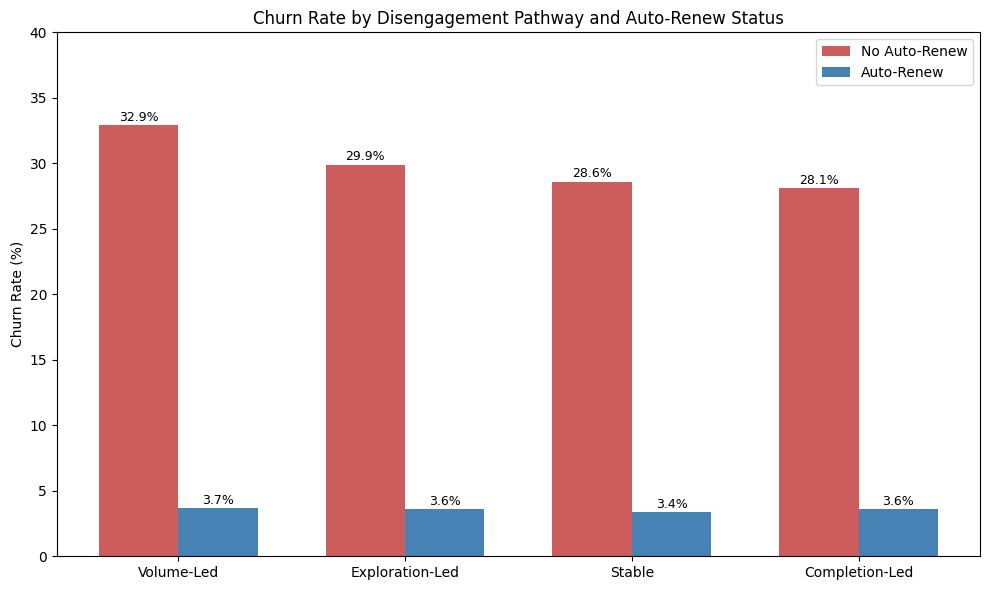

In [113]:
# Visualize churn rate by pathway and auto-renew status
no_autorenew = pathway_churn_df[pathway_churn_df['is_auto_renew'] == 0].set_index('pathway_type')
autorenew = pathway_churn_df[pathway_churn_df['is_auto_renew'] == 1].set_index('pathway_type')

pathway_order = ['Volume-Led', 'Exploration-Led', 'Stable', 'Completion-Led']
no_ar_rates = [no_autorenew.loc[p, 'churn_rate'] for p in pathway_order]
ar_rates = [autorenew.loc[p, 'churn_rate'] for p in pathway_order]

x = np.arange(len(pathway_order))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, no_ar_rates, width, label='No Auto-Renew', color='indianred')
bars2 = ax.bar(x + width/2, ar_rates, width, label='Auto-Renew', color='steelblue')

ax.set_ylabel('Churn Rate (%)')
ax.set_title('Churn Rate by Disengagement Pathway and Auto-Renew Status')
ax.set_xticks(x)
ax.set_xticklabels(pathway_order)
ax.legend()
ax.set_ylim(0, 40)

for bar in bars1:
    ax.annotate(f'{bar.get_height():.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)
for bar in bars2:
    ax.annotate(f'{bar.get_height():.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

The chart illustrates the key finding: pathway type differentiates churn only among non-auto-renew users. Volume-Led users churn nearly 5pp higher than Completion-Led users, suggesting different disengagement patterns may warrant different intervention approaches.

In [ ]:
# Profile pathway segments by demographics
run_query("""
WITH user_periods AS (
    SELECT 
        msno,
        CASE 
            WHEN date BETWEEN 20160801 AND 20161031 THEN 'baseline'
            WHEN date BETWEEN 20161101 AND 20161231 THEN 'transition'
        END AS period,
        SUM(total_secs) AS total_secs,
        SUM(num_100) AS songs_completed,
        SUM(num_25 + num_50 + num_75 + num_985 + num_100) AS songs_played,
        SUM(num_unq) AS unique_songs
    FROM kkbox.user_logs
    WHERE date >= 20160801 AND date <= 20161231
        AND total_secs BETWEEN 0 AND 57600
    GROUP BY msno, period
),

users_both_periods AS (
    SELECT msno
    FROM user_periods
    WHERE period IS NOT NULL
    GROUP BY msno
    HAVING COUNT(DISTINCT period) = 2
),

dimensions AS (
    SELECT 
        p.msno,
        p.period,
        p.total_secs AS volume,
        SAFE_DIVIDE(p.songs_completed, p.songs_played) AS completion_rate,
        SAFE_DIVIDE(p.unique_songs, p.songs_played) AS exploration_rate
    FROM user_periods p
    INNER JOIN users_both_periods u ON p.msno = u.msno
    WHERE p.period IS NOT NULL
),

wide AS (
    SELECT 
        msno,
        MAX(CASE WHEN period = 'baseline' THEN volume END) AS baseline_volume,
        MAX(CASE WHEN period = 'transition' THEN volume END) AS transition_volume,
        MAX(CASE WHEN period = 'baseline' THEN completion_rate END) AS baseline_completion,
        MAX(CASE WHEN period = 'transition' THEN completion_rate END) AS transition_completion,
        MAX(CASE WHEN period = 'baseline' THEN exploration_rate END) AS baseline_exploration,
        MAX(CASE WHEN period = 'transition' THEN exploration_rate END) AS transition_exploration
    FROM dimensions
    GROUP BY msno
),

changes AS (
    SELECT 
        msno,
        SAFE_DIVIDE(transition_volume - baseline_volume, baseline_volume) AS volume_change,
        SAFE_DIVIDE(transition_completion - baseline_completion, baseline_completion) AS completion_change,
        SAFE_DIVIDE(transition_exploration - baseline_exploration, baseline_exploration) AS exploration_change
    FROM wide
),

pathways AS (
    SELECT 
        msno,
        CASE
            WHEN volume_change >= -0.15 AND completion_change >= -0.15 AND exploration_change >= -0.15 
                THEN 'Stable'
            WHEN volume_change <= completion_change AND volume_change <= exploration_change AND volume_change < -0.15
                THEN 'Volume-Led'
            WHEN completion_change <= volume_change AND completion_change <= exploration_change AND completion_change < -0.15
                THEN 'Completion-Led'
            WHEN exploration_change <= volume_change AND exploration_change <= completion_change AND exploration_change < -0.15
                THEN 'Exploration-Led'
            ELSE 'Mixed'
        END AS pathway_type
    FROM changes
    WHERE volume_change IS NOT NULL 
        AND completion_change IS NOT NULL 
        AND exploration_change IS NOT NULL
)

SELECT 
    p.pathway_type,
    COUNT(*) AS users,
    ROUND(AVG(CASE WHEN m.bd BETWEEN 13 AND 70 THEN m.bd END), 1) AS avg_age,
    ROUND(SUM(CASE WHEN m.gender = 'male' THEN 1 ELSE 0 END) * 100.0 / 
          NULLIF(SUM(CASE WHEN m.gender IS NOT NULL THEN 1 ELSE 0 END), 0), 1) AS pct_male,
    ROUND(SUM(CASE WHEN m.registered_via = 7 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) AS pct_channel_7
FROM pathways p
JOIN kkbox.members m ON p.msno = m.msno
GROUP BY p.pathway_type
ORDER BY users DESC
""")

,pathway_type,users,avg_age,pct_male,pct_channel_7
0,Volume-Led,617475,29.6,52.5,39.0
1,Stable,250140,29.1,52.2,40.2
2,Exploration-Led,67671,30.3,50.5,43.1
3,Completion-Led,51609,30.0,53.2,40.2


In [52]:
# Channel 7 baseline for pathway analysis population
run_query("""
SELECT 
    COUNT(*) AS total_users,
    SUM(CASE WHEN m.registered_via = 7 THEN 1 ELSE 0 END) AS channel_7_users,
    ROUND(SUM(CASE WHEN m.registered_via = 7 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) AS pct_channel_7
FROM (
    SELECT msno
    FROM kkbox.user_logs
    WHERE date >= 20160801 AND date <= 20161231
        AND total_secs BETWEEN 0 AND 57600
    GROUP BY msno
    HAVING COUNT(DISTINCT CASE 
        WHEN date BETWEEN 20160801 AND 20161031 THEN 'baseline'
        WHEN date BETWEEN 20161101 AND 20161231 THEN 'transition'
    END) = 2
) u
JOIN kkbox.members m ON u.msno = m.msno
""")

,total_users,channel_7_users,pct_channel_7
0,999217,394280,39.5


Pathway segments show modest demographic variation. Average age ranges from 29.1 to 30.3. Channel 7 registration ranges from 39.0-43.1% versus a 39.5% baseline—Exploration-Led users are slightly over-indexed on channel 7. Gender ranges from 50.5-53.2%. The demographic variation (up to 9% relative to baseline for channel 7) is smaller than the churn rate variation (16% relative difference), and no demographic pattern clearly maps onto churn risk. Volume-Led has the highest churn but the lowest channel 7 rate.

In [2]:
# Sensitivity analysis: test thresholds of -0.10, -0.15, -0.20
run_query("""
WITH user_periods AS (
    SELECT 
        msno,
        CASE 
            WHEN date BETWEEN 20160801 AND 20161031 THEN 'baseline'
            WHEN date BETWEEN 20161101 AND 20161231 THEN 'transition'
            WHEN date BETWEEN 20170101 AND 20170131 THEN 'final'
        END AS period,
        SUM(total_secs) AS total_secs,
        SUM(num_100) AS songs_completed,
        SUM(num_25 + num_50 + num_75 + num_985 + num_100) AS songs_played,
        SUM(num_unq) AS unique_songs
    FROM kkbox.user_logs
    WHERE date >= 20160801 AND date <= 20170131
        AND total_secs BETWEEN 0 AND 57600
    GROUP BY msno, period
),
users_all_periods AS (
    SELECT msno
    FROM user_periods
    GROUP BY msno
    HAVING COUNT(DISTINCT period) = 3
),
dimensions AS (
    SELECT 
        p.msno,
        p.period,
        p.total_secs AS volume,
        SAFE_DIVIDE(p.songs_completed, p.songs_played) AS completion_rate,
        SAFE_DIVIDE(p.unique_songs, p.songs_played) AS exploration_rate
    FROM user_periods p
    INNER JOIN users_all_periods u ON p.msno = u.msno
),
wide AS (
    SELECT 
        msno,
        MAX(CASE WHEN period = 'baseline' THEN volume END) AS baseline_volume,
        MAX(CASE WHEN period = 'transition' THEN volume END) AS transition_volume,
        MAX(CASE WHEN period = 'baseline' THEN completion_rate END) AS baseline_completion,
        MAX(CASE WHEN period = 'transition' THEN completion_rate END) AS transition_completion,
        MAX(CASE WHEN period = 'baseline' THEN exploration_rate END) AS baseline_exploration,
        MAX(CASE WHEN period = 'transition' THEN exploration_rate END) AS transition_exploration
    FROM dimensions
    GROUP BY msno
),
changes AS (
    SELECT 
        msno,
        SAFE_DIVIDE(transition_volume - baseline_volume, baseline_volume) AS volume_change,
        SAFE_DIVIDE(transition_completion - baseline_completion, baseline_completion) AS completion_change,
        SAFE_DIVIDE(transition_exploration - baseline_exploration, baseline_exploration) AS exploration_change
    FROM wide
),
pathways_all AS (
    SELECT 
        msno,
        volume_change,
        completion_change,
        exploration_change,
        -- 10% threshold
        CASE
            WHEN volume_change >= -0.10 AND completion_change >= -0.10 AND exploration_change >= -0.10 THEN 'Stable'
            WHEN volume_change <= completion_change AND volume_change <= exploration_change AND volume_change < -0.10 THEN 'Volume-Led'
            WHEN completion_change <= volume_change AND completion_change <= exploration_change AND completion_change < -0.10 THEN 'Completion-Led'
            WHEN exploration_change <= volume_change AND exploration_change <= completion_change AND exploration_change < -0.10 THEN 'Exploration-Led'
            ELSE 'Mixed'
        END AS pathway_10,
        -- 15% threshold
        CASE
            WHEN volume_change >= -0.15 AND completion_change >= -0.15 AND exploration_change >= -0.15 THEN 'Stable'
            WHEN volume_change <= completion_change AND volume_change <= exploration_change AND volume_change < -0.15 THEN 'Volume-Led'
            WHEN completion_change <= volume_change AND completion_change <= exploration_change AND completion_change < -0.15 THEN 'Completion-Led'
            WHEN exploration_change <= volume_change AND exploration_change <= completion_change AND exploration_change < -0.15 THEN 'Exploration-Led'
            ELSE 'Mixed'
        END AS pathway_15,
        -- 20% threshold
        CASE
            WHEN volume_change >= -0.20 AND completion_change >= -0.20 AND exploration_change >= -0.20 THEN 'Stable'
            WHEN volume_change <= completion_change AND volume_change <= exploration_change AND volume_change < -0.20 THEN 'Volume-Led'
            WHEN completion_change <= volume_change AND completion_change <= exploration_change AND completion_change < -0.20 THEN 'Completion-Led'
            WHEN exploration_change <= volume_change AND exploration_change <= completion_change AND exploration_change < -0.20 THEN 'Exploration-Led'
            ELSE 'Mixed'
        END AS pathway_20
    FROM changes
    WHERE volume_change IS NOT NULL 
        AND completion_change IS NOT NULL 
        AND exploration_change IS NOT NULL
),
latest_txn AS (
    SELECT 
        msno,
        is_auto_renew,
        ROW_NUMBER() OVER (PARTITION BY msno ORDER BY transaction_date DESC) AS rn
    FROM kkbox.transactions
)
SELECT 
    '10%' AS threshold,
    p.pathway_10 AS pathway_type,
    ROUND(SUM(t.is_churn) * 100.0 / COUNT(*), 1) AS churn_rate
FROM pathways_all p
INNER JOIN kkbox.train t ON p.msno = t.msno
INNER JOIN latest_txn lt ON p.msno = lt.msno AND lt.rn = 1
WHERE lt.is_auto_renew = 0
GROUP BY p.pathway_10

UNION ALL

SELECT 
    '15%' AS threshold,
    p.pathway_15 AS pathway_type,
    ROUND(SUM(t.is_churn) * 100.0 / COUNT(*), 1) AS churn_rate
FROM pathways_all p
INNER JOIN kkbox.train t ON p.msno = t.msno
INNER JOIN latest_txn lt ON p.msno = lt.msno AND lt.rn = 1
WHERE lt.is_auto_renew = 0
GROUP BY p.pathway_15

UNION ALL

SELECT 
    '20%' AS threshold,
    p.pathway_20 AS pathway_type,
    ROUND(SUM(t.is_churn) * 100.0 / COUNT(*), 1) AS churn_rate
FROM pathways_all p
INNER JOIN kkbox.train t ON p.msno = t.msno
INNER JOIN latest_txn lt ON p.msno = lt.msno AND lt.rn = 1
WHERE lt.is_auto_renew = 0
GROUP BY p.pathway_20

ORDER BY threshold, churn_rate DESC
""")

,threshold,pathway_type,churn_rate
0,10%,Volume-Led,32.9
1,10%,Exploration-Led,29.2
2,10%,Stable,28.3
3,10%,Completion-Led,28.0
4,15%,Volume-Led,32.9
5,15%,Exploration-Led,29.9
6,15%,Stable,28.6
7,15%,Completion-Led,28.1
8,20%,Volume-Led,32.9
9,20%,Exploration-Led,29.8


The finding is consistent across thresholds. Volume-Led users consistently churn at 32.9% regardless of threshold. The gap between Volume-Led and Completion-Led is 4.9pp at 10%, 4.8pp at 15%, and 4.0pp at 20%. The pattern holds: users whose volume declines most churn more than users whose completion declines most.

Overall, the disengagement pathway analysis found that the initial finding that "listening activity doesn't predict churn" was incomplete. Listening activity doesn't predict churn overall because auto-renew masks the relationship. Among users without auto-renew, disengagement patterns do predict churn: Volume-Led users churn at 32.9% versus 28.1% for Completion-Led.

### Data-Driven Validation: Clustering Analysis

The pathway analysis used rule-based classification: a -15% threshold for significant decline, then assignment by which dimension declined most. Does this structure emerge from unsupervised learning?

**Approach:** K-means clustering on the 3 change variables for non-auto-renew users who experienced significant decline (excluding Stable users). Values are capped at [-1, 0] before clustering: -1 represents complete cessation (-100%), and 0 treats all increases as "didn't decline." This capping ensures consistency with pathway logic (where positive changes are ignored) and prevents extreme outliers from dominating cluster formation.

In [ ]:
# Pull change variables for clustering (non-auto-renew users with significant decline)
user_changes_df = run_query("""
WITH user_periods AS (
    SELECT 
        msno,
        CASE 
            WHEN date BETWEEN 20160801 AND 20161031 THEN 'baseline'
            WHEN date BETWEEN 20161101 AND 20161231 THEN 'transition'
            WHEN date BETWEEN 20170101 AND 20170131 THEN 'final'
        END AS period,
        SUM(total_secs) AS total_secs,
        SUM(num_100) AS songs_completed,
        SUM(num_25 + num_50 + num_75 + num_985 + num_100) AS songs_played,
        SUM(num_unq) AS unique_songs
    FROM kkbox.user_logs
    WHERE date >= 20160801 AND date <= 20170131
        AND total_secs BETWEEN 0 AND 57600
    GROUP BY msno, period
),

users_all_periods AS (
    SELECT msno
    FROM user_periods
    GROUP BY msno
    HAVING COUNT(DISTINCT period) = 3
),

dimensions AS (
    SELECT 
        p.msno,
        p.period,
        p.total_secs AS volume,
        SAFE_DIVIDE(p.songs_completed, p.songs_played) AS completion_rate,
        SAFE_DIVIDE(p.unique_songs, p.songs_played) AS exploration_rate
    FROM user_periods p
    INNER JOIN users_all_periods u ON p.msno = u.msno
),

wide AS (
    SELECT 
        msno,
        MAX(CASE WHEN period = 'baseline' THEN volume END) AS baseline_volume,
        MAX(CASE WHEN period = 'transition' THEN volume END) AS transition_volume,
        MAX(CASE WHEN period = 'baseline' THEN completion_rate END) AS baseline_completion,
        MAX(CASE WHEN period = 'transition' THEN completion_rate END) AS transition_completion,
        MAX(CASE WHEN period = 'baseline' THEN exploration_rate END) AS baseline_exploration,
        MAX(CASE WHEN period = 'transition' THEN exploration_rate END) AS transition_exploration
    FROM dimensions
    GROUP BY msno
),

changes AS (
    SELECT 
        msno,
        SAFE_DIVIDE(transition_volume - baseline_volume, baseline_volume) AS volume_change,
        SAFE_DIVIDE(transition_completion - baseline_completion, baseline_completion) AS completion_change,
        SAFE_DIVIDE(transition_exploration - baseline_exploration, baseline_exploration) AS exploration_change
    FROM wide
),

pathways AS (
    SELECT 
        msno,
        volume_change,
        completion_change,
        exploration_change,
        CASE
            WHEN volume_change >= -0.15 AND completion_change >= -0.15 AND exploration_change >= -0.15 
                THEN 'Stable'
            WHEN volume_change <= completion_change AND volume_change <= exploration_change AND volume_change < -0.15
                THEN 'Volume-Led'
            WHEN completion_change <= volume_change AND completion_change <= exploration_change AND completion_change < -0.15
                THEN 'Completion-Led'
            WHEN exploration_change <= volume_change AND exploration_change <= completion_change AND exploration_change < -0.15
                THEN 'Exploration-Led'
            ELSE 'Mixed'
        END AS pathway
    FROM changes
    WHERE volume_change IS NOT NULL 
        AND completion_change IS NOT NULL 
        AND exploration_change IS NOT NULL
),

latest_txn AS (
    SELECT 
        msno,
        is_auto_renew,
        ROW_NUMBER() OVER (PARTITION BY msno ORDER BY transaction_date DESC) AS rn
    FROM kkbox.transactions
)

SELECT 
    p.msno,
    p.volume_change,
    p.completion_change,
    p.exploration_change,
    p.pathway,
    t.is_churn
FROM pathways p
INNER JOIN latest_txn lt ON p.msno = lt.msno AND lt.rn = 1
LEFT JOIN kkbox.train t ON p.msno = t.msno
WHERE lt.is_auto_renew = 0
    AND p.pathway != 'Stable'
""")

print(f"Non-auto-renew users with significant decline: {len(user_changes_df):,}")
print(f"\nChange variable statistics:")
print(user_changes_df[['volume_change', 'completion_change', 'exploration_change']].describe().round(3))
print(f"\nPathway distribution:")
print(user_changes_df['pathway'].value_counts())

Non-auto-renew users with significant decline: 150,488

Change variable statistics:
       volume_change  completion_change  exploration_change
count     150488.000         150488.000          150488.000
mean           0.702              0.007               0.008
std           35.462              0.500               0.235
min           -1.000             -1.000              -0.966
25%           -0.559             -0.083              -0.068
50%           -0.402             -0.003               0.003
75%           -0.260              0.066               0.067
max         5368.691             89.675              19.301

Pathway distribution:
pathway
Volume-Led         131002
Exploration-Led     12609
Completion-Led       6877
Name: count, dtype: int64


Users with valid change data: 150,488

After capping at [-1, 0]:
       volume_change  completion_change  exploration_change
count     150488.000         150488.000          150488.000
mean          -0.409             -0.062              -0.056
std            0.224              0.112               0.103
min           -1.000             -1.000              -0.966
25%           -0.559             -0.083              -0.068
50%           -0.402             -0.003               0.000
75%           -0.260              0.000               0.000
max            0.000              0.000               0.000
k=2: silhouette=0.472
k=3: silhouette=0.473
k=4: silhouette=0.352
k=5: silhouette=0.373
k=6: silhouette=0.376
k=7: silhouette=0.377

Selected k=3


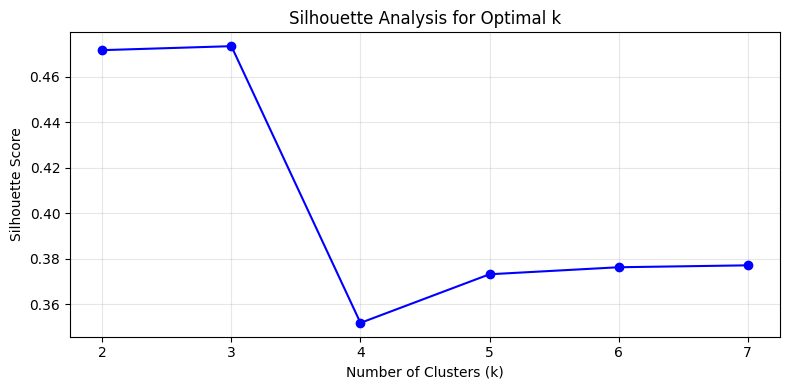

In [56]:
# K-means clustering on change variables
# Prepare features
feature_cols = ['volume_change', 'completion_change', 'exploration_change']
features = user_changes_df[feature_cols].copy()

# Remove any rows with missing values
valid_mask = features.notna().all(axis=1)
features = features[valid_mask]
user_data = user_changes_df[valid_mask].copy()

print(f"Users with valid change data: {len(features):,}")

# Cap values at [-1, 0]: -1 = complete cessation, 0 = no decline (all increases treated as "didn't decline")
for col in features.columns:
    features[col] = features[col].clip(-1, 0)

print(f"\nAfter capping at [-1, 0]:")
print(features.describe().round(3))

# Standardize
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Find optimal k using silhouette score
silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(features_scaled)
    score = silhouette_score(features_scaled, labels_temp, sample_size=min(50000, len(features)), random_state=42)
    silhouette_scores.append(score)
    print(f"k={k}: silhouette={score:.3f}")

optimal_k = list(k_range)[np.argmax(silhouette_scores)]
print(f"\nSelected k={optimal_k}")

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [57]:
# Fit k-means with selected k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
user_data['cluster'] = kmeans.fit_predict(features_scaled)

# Cluster centroids (in original scale)
centroids_scaled = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)
centroid_df = pd.DataFrame(centroids, columns=feature_cols)
centroid_df.index.name = 'cluster'

print("Cluster centroids (average change values):")
print(centroid_df.round(3))

print(f"\nCluster distribution:")
for i in range(optimal_k):
    count = (user_data['cluster'] == i).sum()
    pct = count / len(user_data) * 100
    print(f"  Cluster {i}: {count:,} users ({pct:.1f}%)")

Cluster centroids (average change values):
         volume_change  completion_change  exploration_change
cluster                                                      
0               -0.167             -0.024              -0.273
1               -0.439             -0.029              -0.023
2               -0.483             -0.298              -0.031

Cluster distribution:
  Cluster 0: 19,426 users (12.9%)
  Cluster 1: 112,095 users (74.5%)
  Cluster 2: 18,967 users (12.6%)


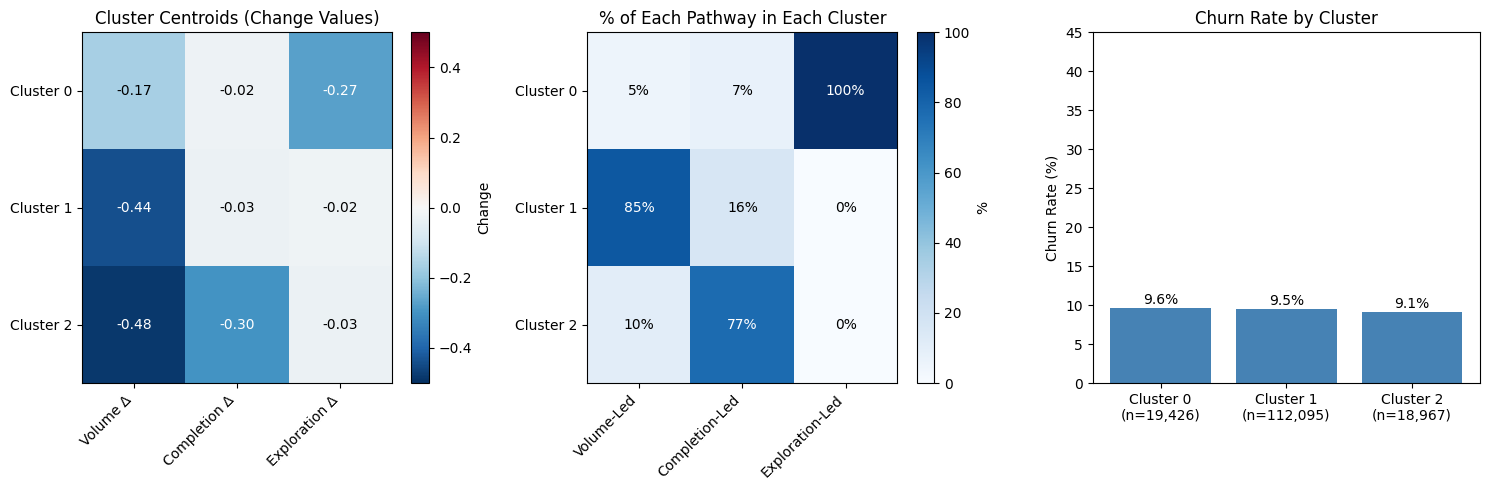


Cluster composition (% of each cluster that is each pathway):
pathway  Completion-Led  Exploration-Led  Volume-Led
cluster                                             
0                   2.6             64.9        32.5
1                   1.0              0.0        99.0
2                  27.9              0.0        72.1

Pathway distribution (% of each pathway that falls in each cluster):
pathway  Completion-Led  Exploration-Led  Volume-Led
cluster                                             
0                   7.3            100.0         4.8
1                  15.8              0.0        84.7
2                  77.0              0.0        10.4


In [58]:
# Cluster profiles, pathway alignment, and churn rates
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Cluster centroids heatmap
centroid_display = centroid_df.copy()
centroid_display.columns = ['Volume Δ', 'Completion Δ', 'Exploration Δ']
im = axes[0].imshow(centroid_display.values, cmap='RdBu_r', aspect='auto', vmin=-0.5, vmax=0.5)
axes[0].set_xticks(range(len(centroid_display.columns)))
axes[0].set_xticklabels(centroid_display.columns, rotation=45, ha='right')
axes[0].set_yticks(range(len(centroid_display.index)))
axes[0].set_yticklabels([f'Cluster {i}' for i in centroid_display.index])
axes[0].set_title('Cluster Centroids (Change Values)')
for i in range(len(centroid_display.index)):
    for j in range(len(centroid_display.columns)):
        val = centroid_display.iloc[i, j]
        color = 'white' if abs(val) > 0.25 else 'black'
        axes[0].text(j, i, f'{val:.2f}', ha='center', va='center', color=color, fontsize=10)
plt.colorbar(im, ax=axes[0], label='Change')

# 2. Cross-tabulation: Cluster vs Pathway (what % of each pathway lands in each cluster)
crosstab = pd.crosstab(user_data['cluster'], user_data['pathway'], normalize='columns') * 100
pathway_order = ['Volume-Led', 'Completion-Led', 'Exploration-Led']
crosstab = crosstab[[p for p in pathway_order if p in crosstab.columns]]
im2 = axes[1].imshow(crosstab.values, cmap='Blues', aspect='auto', vmin=0, vmax=100)
axes[1].set_xticks(range(len(crosstab.columns)))
axes[1].set_xticklabels(crosstab.columns, rotation=45, ha='right')
axes[1].set_yticks(range(len(crosstab.index)))
axes[1].set_yticklabels([f'Cluster {i}' for i in crosstab.index])
axes[1].set_title('% of Each Pathway in Each Cluster')
for i in range(len(crosstab.index)):
    for j in range(len(crosstab.columns)):
        val = crosstab.iloc[i, j]
        color = 'white' if val > 50 else 'black'
        axes[1].text(j, i, f'{val:.0f}%', ha='center', va='center', color=color, fontsize=10)
plt.colorbar(im2, ax=axes[1], label='%')

# 3. Churn rates by cluster
churn_by_cluster = user_data.groupby('cluster').agg(
    users=('msno', 'count'),
    churned=('is_churn', 'sum')
)
churn_by_cluster['churn_rate'] = (churn_by_cluster['churned'] / churn_by_cluster['users'] * 100).round(1)

colors = ['indianred' if rate > 30 else 'steelblue' for rate in churn_by_cluster['churn_rate']]
bars = axes[2].bar(range(len(churn_by_cluster)), churn_by_cluster['churn_rate'], color=colors)
axes[2].set_xticks(range(len(churn_by_cluster)))
axes[2].set_xticklabels([f'Cluster {i}\n(n={churn_by_cluster.loc[i, "users"]:,})' for i in churn_by_cluster.index])
axes[2].set_ylabel('Churn Rate (%)')
axes[2].set_title('Churn Rate by Cluster')
axes[2].set_ylim(0, 45)
for bar in bars:
    axes[2].annotate(f'{bar.get_height():.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 3), textcoords='offset points', ha='center')

plt.tight_layout()
plt.show()

# Print both perspectives of the cross-tabulation
print("\nCluster composition (% of each cluster that is each pathway):")
print(pd.crosstab(user_data['cluster'], user_data['pathway'], normalize='index').round(3) * 100)

print("\nPathway distribution (% of each pathway that falls in each cluster):")
print(pd.crosstab(user_data['cluster'], user_data['pathway'], normalize='columns').round(3) * 100)

**Clustering results:**

- **k=3 selected**: k=2 and k=3 tie for highest silhouette score. k=3 was selected as it matches the three non-Stable pathway categories, providing a direct comparison.

- **Cluster 1 (74.5%)**: Volume shows the steepest decline (-0.44), with completion and exploration near zero. This maps directly to the Volume-Led pathway.

- **Cluster 0 (12.9%)**: Exploration shows the steepest decline (-0.27), with volume also declining moderately (-0.17) and completion near zero. This maps to the Exploration-Led pathway.

- **Cluster 2 (12.6%)**: Both volume (-0.48) and completion (-0.30) decline substantially. Users with declining completion tend to also have declining volume, so Completion-Led users cluster here rather than forming a distinct group.

**Validation assessment:** The clustering provides partial validation of the pathway framework. Volume-Led emerges as a distinct cluster (the majority of users). Exploration-Led is also identifiable but less cleanly separated. Completion-Led does not form its own cluster. These users group with multi-dimensional decliners, suggesting the Completion-Led pathway is a rule-based distinction within a broader pattern rather than a naturally separable segment.

## Summary

**Key finding:** Listening activity doesn't predict churn overall because auto-renew masks the signal. Among non-auto-renew users (~30% churn), disengagement patterns do differentiate outcomes.

**Pathway analysis:** Users whose volume declines most steeply (Volume-Led) churn at 32.9% versus 28.1% for Completion-Led (16% relative difference compared to the baseline 30.5%) which was relatively consistent across decline % threshold choices (10-20%).

**Clustering validation:** K-means on change variables (capped at [-1, 0]) found k=2 and k=3 tied for best silhouette score; k=3 was selected to match the three pathway categories. Volume-Led emerges as a distinct, dominant cluster (74.5% of users). Exploration-Led is identifiable but less cleanly separated. Completion-Led does not form a distinct cluster. These users group with multi-dimensional decliners (both volume and completion declining).

**Implication:** The pathway framework identifies meaningful churn risk differences among non-auto-renew users. Volume-Led is both the most common pattern and the highest-risk segment, warranting targeted retention efforts. The rule-based pathway classification captures structure that partially aligns with data-driven clustering, though Completion-Led represents a finer distinction within a broader multi-dimensional decline pattern.